In [1]:
import os
import sys

# Set the project root directory
project_root = os.path.abspath("..")  # Adjust this based on the notebook's location
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np

from local_calibration import LocalDatadependentCalibration
from calibration import load_calibration

local = LocalDatadependentCalibration()

Producing conformal plot: data/out/live_qa_similarity_a=1.00_weighted_removal_fig.png


100%|██████████| 8/8 [00:00<00:00, 609.84it/s]


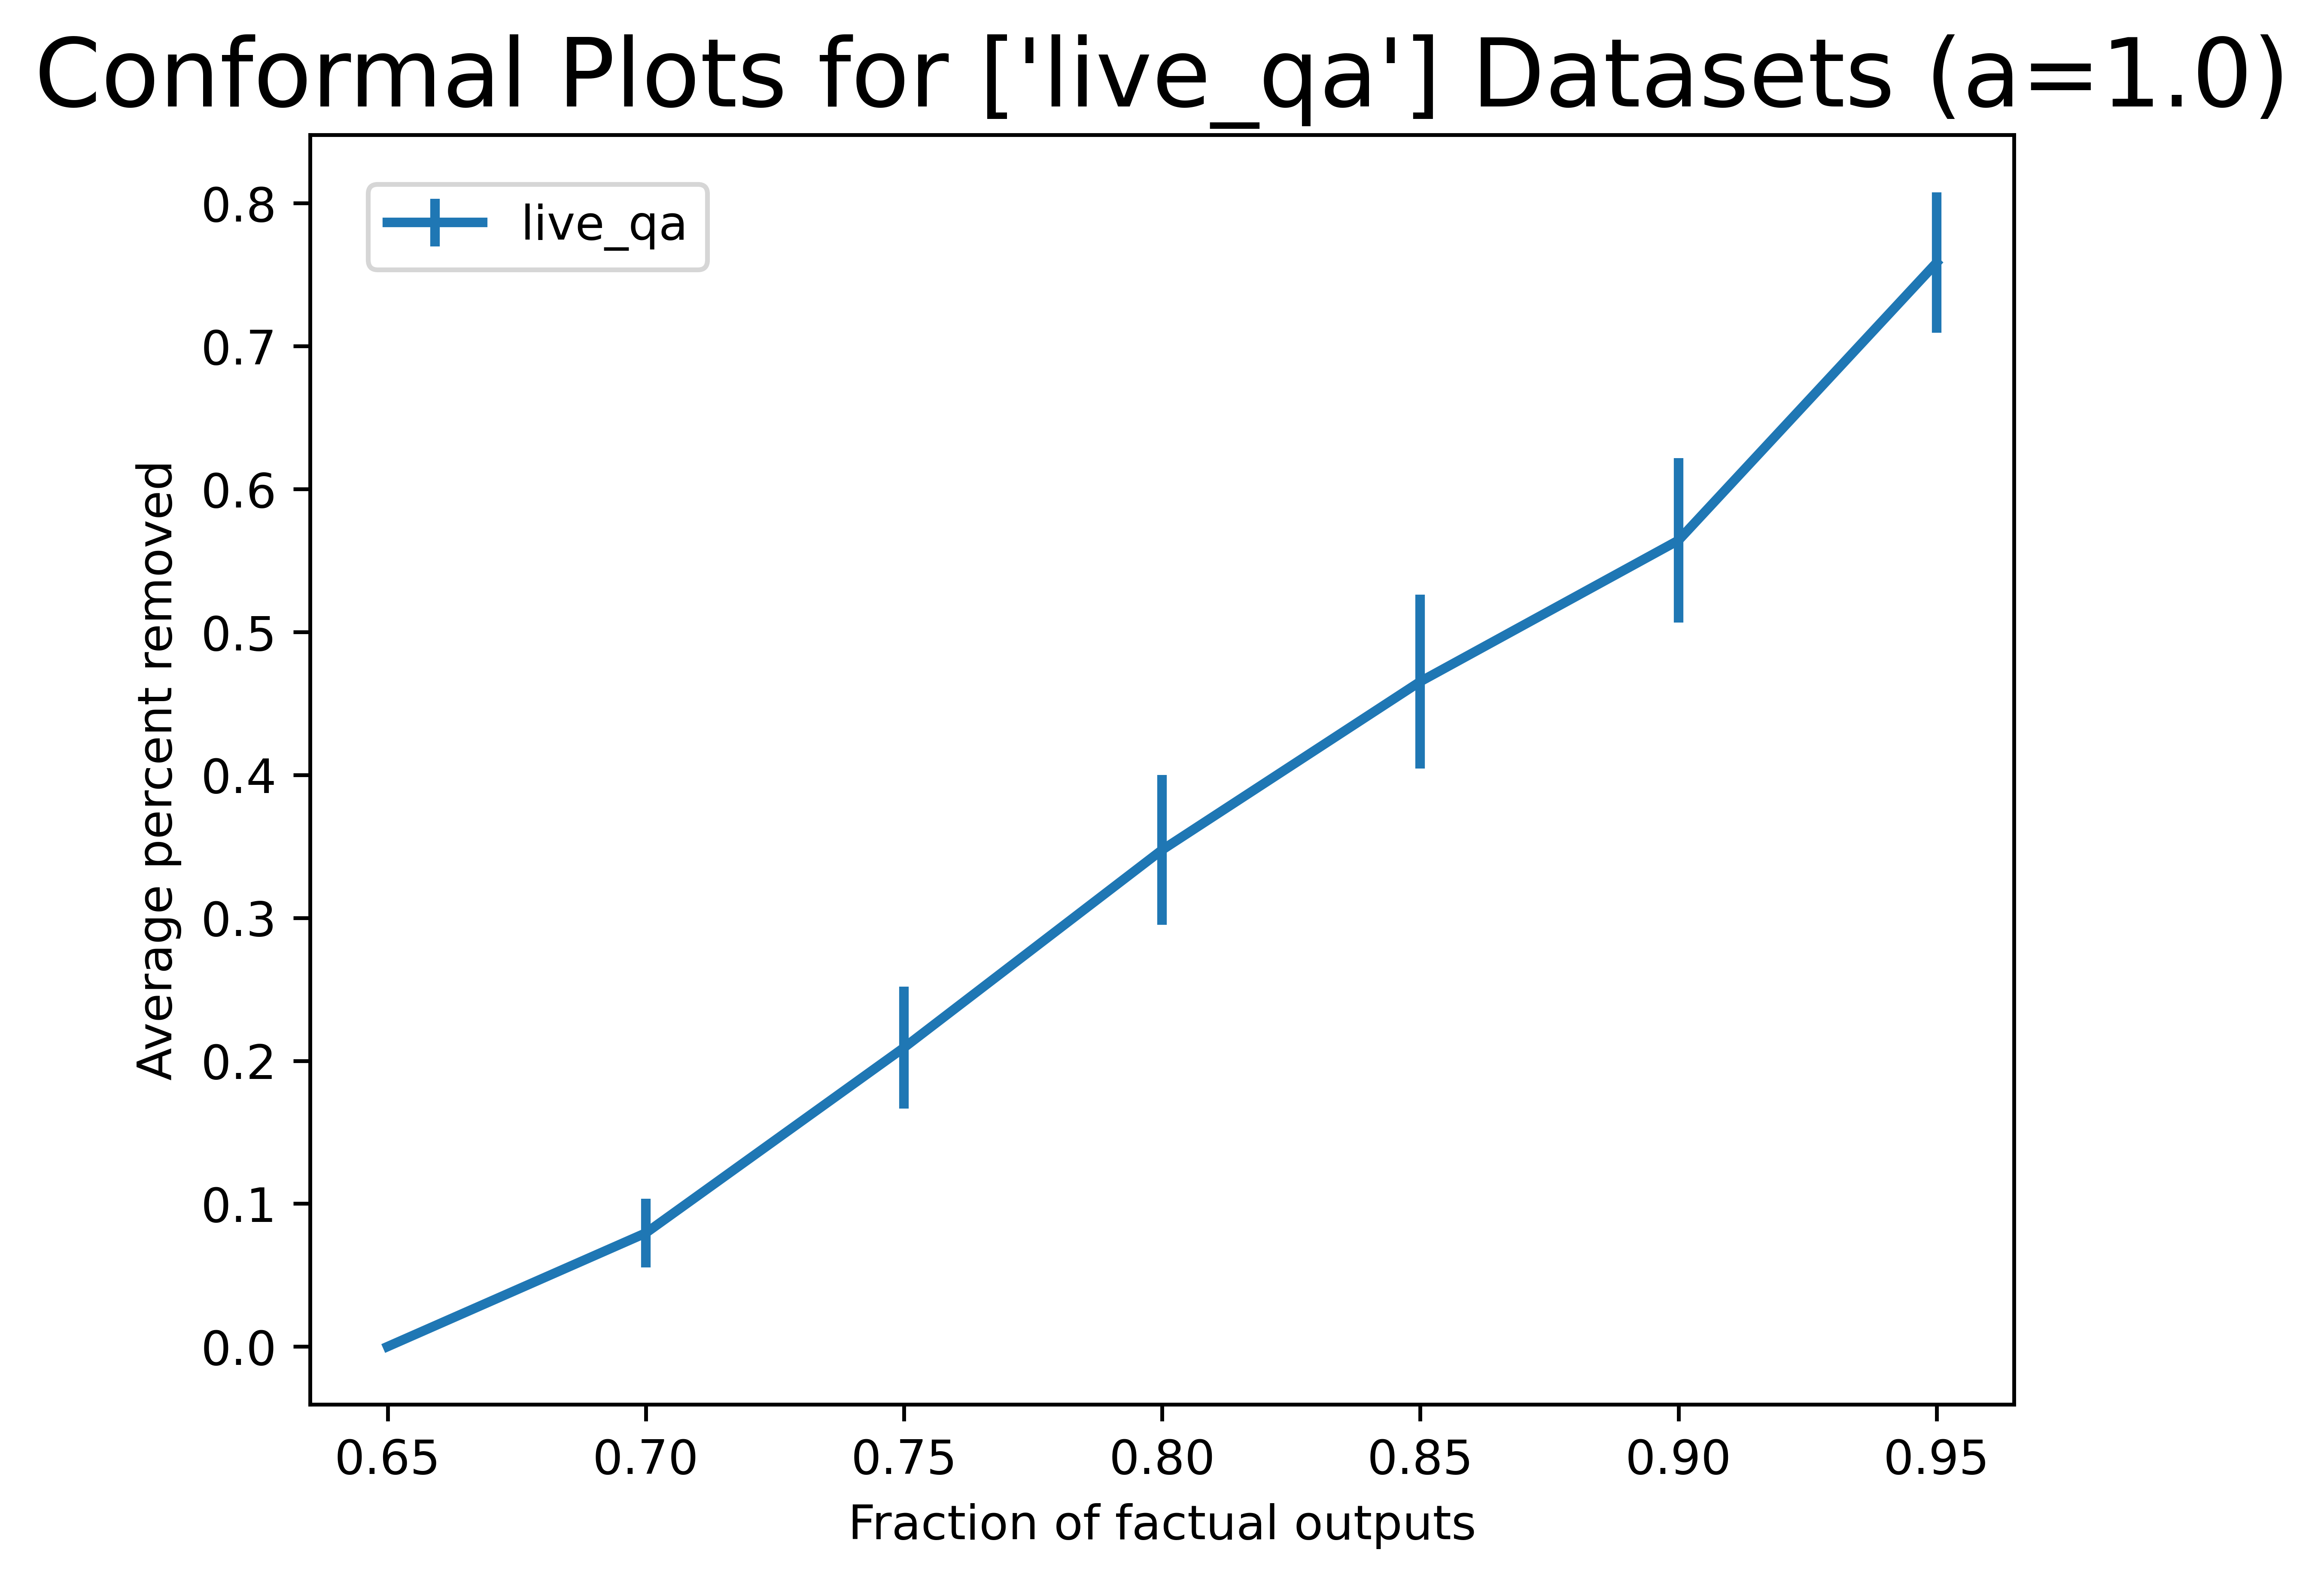

In [3]:
import numpy as np

from local_calibration import LocalDatadependentCalibration
from calibration import load_calibration

local = LocalDatadependentCalibration()
a=1.0
dataset_prefixs = ['live_qa'] #option: medication_qa, healthsearch_qa, kqa_golden, kqa_silver_wogold, live_qa， medlfqav2
method = 'similarity'
alphas = np.arange(0.05, 0.45, 0.05)
datasets = {}
for dataset_prefix in dataset_prefixs:
    data = load_calibration(f"data/out/{dataset_prefix}_subclaims_with_scores.jsonl")
    datasets[dataset_prefix] = data

dsprefixs = "_".join(dataset_prefixs)
fig_filename = f"data/out/{dsprefixs}_{method}_a={a:.2f}_weighted_removal_fig.png"
csv_filename = f"data/out/{dsprefixs}_{method}_a={a:.2f}_weighted_removal.csv"
local.calibrate_removal(
    dataset_prefixs, method, datasets, alphas, a, fig_filename, csv_filename
)

Producing calibration plot: data/out/medlfqav2_900_similarity_a=1.00_calibration_weighted_conditional_fig.png


100%|██████████| 8/8 [03:14<00:00, 24.28s/it]


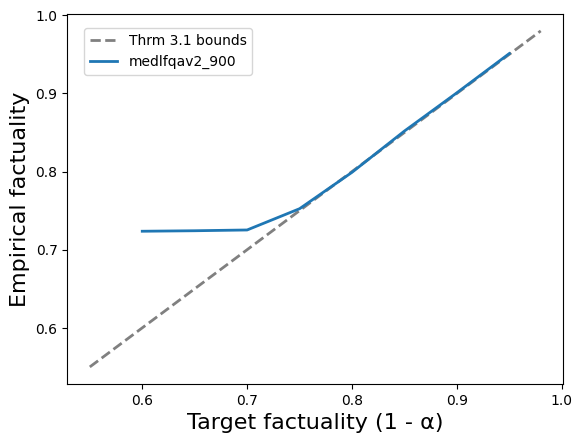

In [3]:
import numpy as np

from local_calibration import LocalDatadependentCalibration
from calibration import load_calibration

local = LocalDatadependentCalibration()

a=1.0
alphas = np.arange(0.05, 0.45, 0.05)
dataset_prefix = 'medlfqav2_900'
confidence_method = 'similarity'
data = load_calibration(f"data/out/{dataset_prefix}_subclaims_with_scores.jsonl")
fig_filename = f"data/out/{dataset_prefix}_{confidence_method}_a={a:.2f}_calibration_weighted_conditional_fig.png"
csv_filename = f"data/out/{dataset_prefix}_{confidence_method}_a={a:.2f}_calibration_weighted_conditional.csv"
local.calibrate_factual(
    dataset_prefix, confidence_method, data, alphas, a, fig_filename, csv_filename
)

100%|██████████| 1000/1000 [01:01<00:00, 16.19it/s]


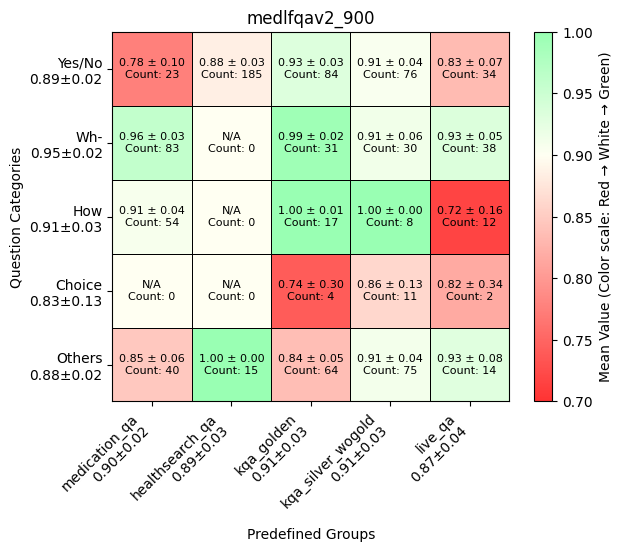

In [3]:
a=1.0
alpha = 0.10
dataset_prefix = 'medlfqav2_900'
confidence_method = 'similarity'
data = load_calibration(f"data/out/{dataset_prefix}_subclaims_with_scores_categorized.jsonl")
fig_filename = f"data/out/{dataset_prefix}_{confidence_method}_alpha={alpha:.2f}_local_coverage_pergroup.png"
csv_filename = f"data/out/{dataset_prefix}_{confidence_method}_alpha={alpha:.2f}_calibration_coverage.csv"
score_filename = f"data/metadata/{dataset_prefix}_calibrate_score.jsonl"
group_names = ["medication_qa", "healthsearch_qa", "kqa_golden", "kqa_silver_wogold", "live_qa"]
categories = ["Yes/No", "Wh-", "How", "Choice", "Others"]

local.calibrate_factual_pergroup(dataset_prefix, confidence_method, data, alpha, a, fig_filename, csv_filename, categories, group_names)

100%|██████████| 1000/1000 [02:14<00:00,  7.44it/s]


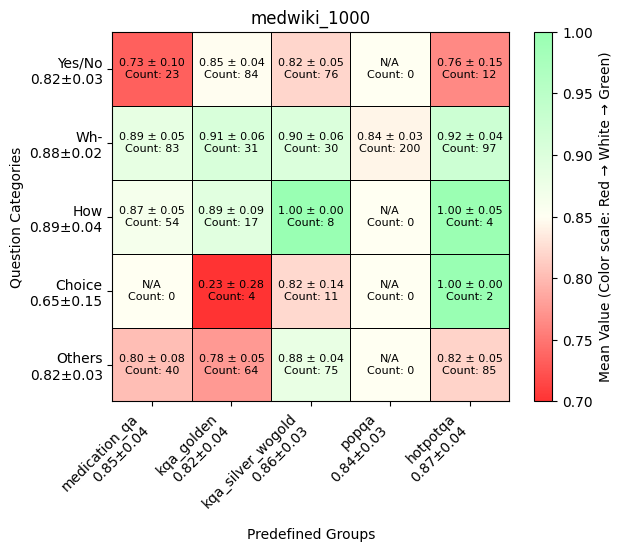

In [4]:
a=1.0
alpha = 0.15
dataset_prefix = 'medwiki_1000'
confidence_method = 'similarity'
data = load_calibration(f"data/out/{dataset_prefix}_subclaims_with_scores_categorized.jsonl")
fig_filename = f"data/out/{dataset_prefix}_{confidence_method}_alpha={alpha:.2f}_marginal_coverage_pergroup.png"
csv_filename = f"data/out/{dataset_prefix}_{confidence_method}_alpha={alpha:.2f}_calibration_coverage.csv"
group_names = ["medication_qa", "kqa_golden", "kqa_silver_wogold", "popqa", "hotpotqa"]
categories = ["Yes/No", "Wh-", "How", "Choice", "Others"]

local.calibrate_factual_pergroup(dataset_prefix, confidence_method, data, alpha, a, fig_filename, csv_filename, categories, group_names)

In [9]:
from collections import defaultdict
import random

def sample_by_group(final_records, group_names, n_per_group):
    # Dictionary to hold records grouped by dataset
    grouped_records = defaultdict(list)

    # Group records by the dataset in record["groups"][0]
    for record in final_records:
        group = record.get("groups", [None])[0]
        if group in group_names:
            grouped_records[group].append(record)

    # Sample from each group
    sampled = []
    for group in group_names:
        records = grouped_records.get(group, [])
        sampled.extend(records[:n_per_group])  # Take n or fewer
        # OR use random sampling if desired:
        # sampled.extend(random.sample(records, min(n_per_group, len(records))))

    return sampled


In [10]:
import random
import json
from calibration import load_calibration, dump_claims

def process_sample(final_records, out_name, datasets, n_per_group):
    
    sampled_items = sample_by_group(final_records, datasets, n_per_group)
    # join certain number of records from each group

    dump_claims(sampled_items, f"data/out/{out_name}_subclaims_with_scores.jsonl")

    calibrate_scores = []
    for dataset in datasets:
        with open(f"data/metadata/{dataset}_calibrate_score.jsonl", "r") as f:
            for line in f:
                item = json.loads(line)
                calibrate_scores.append(item)
    filtered_items = []
    for item in sampled_items:
        for calibrate in calibrate_scores:
            if item["prompt"] == calibrate["query"]:
                calibrate["groups"] = item["groups"]
                filtered_items.append(calibrate)

    # Save the sampled claims with their scores to a new JSONL file
    with open(f"data/metadata/{out_name}_calibrate_score.jsonl", "w") as f:
        for item in filtered_items:
            f.write(json.dumps(item) + "\n")




In [14]:
import json
from calibration import load_calibration, dump_claims
from utils.string_utils import categorize_question
def categories_prompts(out_name):
    final_records = load_calibration(f"data/out/{out_name}_subclaims_with_scores.jsonl")
    for record in final_records:
        question = record.get("prompt", "")
        category = categorize_question(question)
        record["category"] = category

    #count the number of each category
    categories_count = {}
    for record in final_records:
        category = record.get("category", "Unknown")
        if category not in categories_count:
            categories_count[category] = 0
        categories_count[category] += 1
    print(categories_count)

    # Save the updated records to a new JSONL file
    dump_claims(final_records, f"data/out/{out_name}_subclaims_with_scores_categorized.jsonl")




In [ ]:
#medlfqav2_900
final_records = load_calibration("data/out/medlfqav2_subclaims_with_scores.jsonl")
out_name = "medlfqav2_900"
datasets = ["medication_qa", "healthsearch_qa", "kqa_golden", "kqa_silver_wogold", "live_qa"]
n_per_group = 200
process_sample(final_records, out_name, datasets, n_per_group)
categories_prompts(out_name)


In [15]:
#mix wiki
final_records = load_calibration("data/out/medlfqav2_subclaims_with_scores.jsonl")
hotpot_records = load_calibration("data/out/hotpotqa_subclaims_with_scores.jsonl")
popqa_records = load_calibration("data/out/popqa_subclaims_with_scores.jsonl")
final_records.extend(hotpot_records)
final_records.extend(popqa_records)
out_name = "medwiki_1000"
datasets = ["medication_qa", "kqa_golden", "kqa_silver_wogold", "popqa", "hotpotqa"]
n_per_group = 200
process_sample(final_records, out_name, datasets, n_per_group)
categories_prompts(out_name)

{'How': 83, 'Wh-': 441, 'Others': 264, 'Yes/No': 195, 'Choice': 17}
